In [3]:
import numpy as np
import torch.optim as optim

import gym

from reinforce import PolicyNetwork, reinforce

In [4]:
env_name = "LunarLander-v2"

env = gym.make(env_name)
eval_env = gym.make(env_name)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print("state size:", state_size)
print("action size:", action_size)

state size: 8
action size: 4


# TEST RUN

In [7]:
# misschien de beste HPs
hidden_nodes = 64
n_training_episodes = 10_000
max_timesteps = 1_000
gamma = .99
learning_rate = 0.001
entropy = 0.001

policy = PolicyNetwork(state_size, action_size, hidden_nodes)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)	

scores, eval_episodes = reinforce(
    env,
    policy,
	optimizer,
	n_training_episodes, 
	gamma, 
	100,
	max_timesteps,
	entropy,
	verbose=True
)

<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v2>>>>>
10000


/Users/kaygijzen/Downloads/RL3/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100 	Average Score: -145.53379327391835
Episode 200 	Average Score: -130.20391917539396
Episode 300 	Average Score: -119.36059794253886
Episode 400 	Average Score: -137.96045799690904
Episode 500 	Average Score: -83.90726554901221
Episode 600 	Average Score: -104.17258077840297
Episode 700 	Average Score: -133.1196316035251
Episode 800 	Average Score: -115.20273487845338
Episode 900 	Average Score: -109.3682565135864
Episode 1000 	Average Score: -117.48582958815277
Episode 1100 	Average Score: -107.21613710514642
Episode 1200 	Average Score: -115.23609693706219
Episode 1300 	Average Score: -124.44177294694425
Episode 1400 	Average Score: -103.77270622662077
Episode 1500 	Average Score: -101.74747766242926
Episode 1600 	Average Score: -97.92368100114939
Episode 1700 	Average Score: -107.8313970964324
Episode 1800 	Average Score: -110.4731969091589
Episode 1900 	Average Score: -148.90958681894674
Episode 2000 	Average Score: -111.75512111845322
Episode 2100 	Average Score: -100.0

In [8]:
def play(policy, n_eval_episodes=10, verbose=False):
	venv = gym.make(env_name, render_mode="human")
	episode_rewards = []
	for _ in range(n_eval_episodes):
		state, _ = venv.reset()
		done = False
		total_rewards_ep = 0
		
		while True:
			action, _, _ = policy.act(state)

			if verbose: print(action)

			next_state, reward, done, truncated, _ = venv.step(action)
			total_rewards_ep += reward
			
			if done or truncated:
				break
			state = next_state
			
		print(total_rewards_ep)
		episode_rewards.append(total_rewards_ep)
	mean_reward = np.mean(episode_rewards)
	std_reward = np.std(episode_rewards)

	venv.close()

	return mean_reward, std_reward

play(policy)

140.93844838478776
129.25457576811348
154.32482180627167
145.24651133243984
122.6632305709336
129.65508335739082
114.88976922783439
107.98148088227249
153.96475708155234
159.56604547333012


(135.84847238849267, 16.786465141476118)

# EVALUATION

In [ ]:
from Helper import LearningCurvePlot, smooth
import time

def average_over_repetitions(n_repetitions, n_training_episodes, max_episode_length, learning_rate, hidden_nodes, gamma,
                            eta_entropy, smoothing_window=None, eval_interval=100):

	returns_over_repetitions = []
	now = time.time()
	for _ in range(n_repetitions): 
		policy = PolicyNetwork(state_size, action_size, hidden_nodes)
		optimizer = optim.Adam(policy.parameters(), lr=learning_rate)	
		
		eval_rewards, eval_episodes = reinforce(policy,
							optimizer,
							n_training_episodes, 
							gamma, 
							eval_interval,
							max_episode_length,
							eta_entropy,
							verbose=True)

		returns_over_repetitions.append(eval_rewards)
		
	print('Running one setting takes {} minutes'.format((time.time()-now)/60))
	learning_curve = np.mean(np.array(returns_over_repetitions),axis=0) # average over repetitions  
	if smoothing_window is not None: 
		learning_curve = smooth(learning_curve,smoothing_window) # additional smoothing
	return learning_curve, eval_episodes

Episode 100 	Average Score: -211.4793709563272
Episode 200 	Average Score: -97.36956931562342
Episode 300 	Average Score: -98.98249221569975
Episode 400 	Average Score: -122.67931672058901
Episode 500 	Average Score: -120.61719160738771
Episode 600 	Average Score: -145.25893091436654
Episode 700 	Average Score: -102.4835001032134
Episode 800 	Average Score: -104.95805397954462
Episode 900 	Average Score: -117.33165665526171
Episode 1000 	Average Score: -122.70511176903965
Episode 1100 	Average Score: -115.9881349240762
Episode 1200 	Average Score: -151.15901396739412
Episode 1300 	Average Score: -110.13887421664144
Episode 1400 	Average Score: -90.55770223307232
Episode 1500 	Average Score: -107.38697944811818
Episode 1600 	Average Score: -119.15511558556337
Episode 1700 	Average Score: -100.74343526051489
Episode 1800 	Average Score: -69.93584390969771
Episode 1900 	Average Score: -97.1565168008422
Episode 2000 	Average Score: -41.88498772178586
Episode 2100 	Average Score: -86.857387

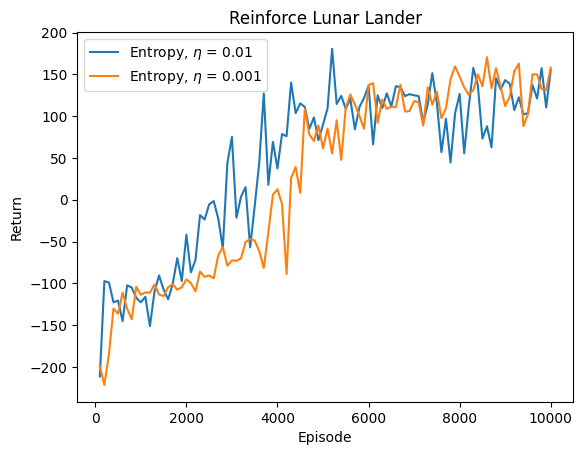

In [ ]:
hidden_nodes = 64
n_training_episodes = 10_000
max_timesteps = 1_000
gamma = .99
learning_rate = 0.001

Plot = LearningCurvePlot(title = 'Reinforce Lunar Lander')    

entropies = [0.01, 0.001]
learning_rates = [0.01, 0.001] #TODO:
for entropy in entropies:        
	learning_curve, eval_episodes = average_over_repetitions(
      	1, 
		n_training_episodes, 
		max_timesteps, 
		learning_rate,
		hidden_nodes,
		gamma,
		entropy, 
		smoothing_window=None, 
		eval_interval=100)
	Plot.add_curve(eval_episodes, learning_curve, label=r'Entropy, $\eta$ = {}'.format(entropy))  

Plot.save('reinforce_lunar_lander.png')

In [ ]:
# import os
# directory = os.path.join(os.getcwd(), "weights")

# # Check if the directory exists
# if not os.path.exists(directory):
#     # Create the directory if it doesn't exist
#     os.makedirs(directory)

# file_path = os.path.join(directory, f"model_nodes={hidden_nodes}_gamma={gamma}_lr={learning_rate}_entropy={entropy}.pth")
# torch.save(policy.state_dict(), file_path)